# Benchmarking MI estimators in high dimension using Gaussian

Here we use correlated Gaussians in high dimension to explore how MI estimators behave in settings with different ambient and (shared) intrinsic dimensionality.

This benchmark studies 6 estimators across 9 $k$ values, 15 $d$ values, and 10 true MIs from 0 to 2 bits. In total 2850 datasets. 

In [1]:
%%capture

from lmi import lmi
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm
import torch
from scipy.stats import kendalltau

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
def generate_gaussian_dataset(ambient, intrinsic, nuisance, antidiag, samples=10**3):
    
    assert intrinsic+nuisance <= ambient, "Dimensionality not adding up"
    
    X_nuisance = np.random.normal(size=(samples, nuisance))
    Y_nuisance = np.random.normal(size=(samples, nuisance))


    cov = np.array([[6, antidiag], [antidiag, 3.5]])
    
    pts = [np.random.multivariate_normal([0, 0], cov, 
                                         size=samples) for i in range(intrinsic)]
    
    pts = np.hstack(pts)
    
    # one copy of the intrinsic dimensions
    Xs = pts[:, [i for i in range(0, 2*intrinsic, 2)]]
    Ys = pts[:, [i for i in range(1, 2*intrinsic, 2)]]
    
    # then randomly sample them to make up the rest of the dimensions
    X_redundant = pts[:, np.random.choice(range(0, 2*intrinsic, 2), 
                                   size = (ambient-(intrinsic+nuisance)))]
    
    Y_redundant = pts[:, np.random.choice(range(1, 2*intrinsic, 2), 
                               size = (ambient-(intrinsic+nuisance)))]
    
    Xs = np.hstack((Xs, X_redundant, X_nuisance))
    Ys = np.hstack((Ys, Y_redundant, Y_nuisance))
    
    return Xs, Ys

def mi_from_rho(rho, intrinsic):
    return -0.5*np.log2((1-(rho/(np.sqrt(6*3.5)))**2))*intrinsic

def rho_from_mi(mi, intrinsic):
    return np.sqrt(6*3.5) * np.sqrt(1 - 2**(-2*mi/intrinsic))

In [3]:
###########################
## Experiment parameters ##
###########################

N_samples = 2*10**3

ambients = np.concatenate((np.arange(1, 6) * 10, 
                           np.arange(1, 6) * 10**2,
                           np.arange(1, 6) * 10**3))

intrinsics = np.arange(1,10)

true_mis = np.linspace(0, 2, 10)

In [4]:
res_d = {

    "True MI" : [],
    "Ambient dimensions" : [],
    "Intrinsic dimensions" : [],
    "Estimator" : [],
    "Estimate" : [],
}


for intrinsic in tqdm(intrinsics,
                      position=0, desc='intrinsic', leave=True):
    
    for ambient in tqdm(ambients, 
                        position=1, desc='ambient', leave=False):
        
        for true_mi in tqdm(true_mis,
                                position=3, desc='anti_diag', leave=False):
            
            if intrinsic <= ambient:
                
                nuisance = (ambient - intrinsic)//2
                anti_diag = rho_from_mi(true_mi, intrinsic)
                
                Xs, Ys = generate_gaussian_dataset(ambient, intrinsic, 
                                                   nuisance, 
                                                   anti_diag,
                                                  samples=N_samples)

                # rescale
                Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
                Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))
                
                infonce = InfoNCE(verbose=False)
                infonce_mi = infonce.estimate(Xs, Ys)
                
                mine = MINE(verbose=False)
                mine_mi = mine.estimate(Xs, Ys)

                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("InfoNCE")
                res_d['Estimate'].append(max(0, infonce_mi/np.log(2)))
                
                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("MINE")
                res_d['Estimate'].append(max(0, mine_mi/np.log(2)))


                s = np.mean(lmi.ksg.mi(Xs, Ys))
                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("KSG")
                res_d['Estimate'].append(s)
                
                #### Padding trick ###
                tXs = Xs.copy()
                tYs = Ys.copy()


                if ambient < 50:
                    tXs = np.tile(Xs, (1, 1 + 50//ambient))
                    tYs = np.tile(Ys, (1, 1 + 50//ambient))
                ####

                s = np.nanmean(lmi.lmi(tXs, tYs, 
                                      regularizer='models.AECross')[0])
                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("LMI")
                res_d['Estimate'].append(s)
                
                s = np.nanmean(lmi.lmi(tXs, tYs,
                                      regularizer='models.AEInfoNCE')[0])
                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("LMI-InfoNCE")
                res_d['Estimate'].append(s)
                
                s = np.nanmean(lmi.lmi(tXs, tYs,
                                      regularizer='models.AEMINE')[0])
                res_d['True MI'].append(true_mi)
                res_d['Ambient dimensions'].append(ambient)
                res_d['Intrinsic dimensions'].append(intrinsic)
                res_d['Estimator'].append("LMI-MINE")
                res_d['Estimate'].append(s)

res_df = pd.DataFrame(res_d)

intrinsic:   0%|          | 0/9 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

ambient:   0%|          | 0/15 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

anti_diag:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
g = res_df.groupby(['Ambient dimensions', 'Intrinsic dimensions', 'Estimator'])
def kendall(group):
    t = group['True MI']
    e = group['Estimate']
    return kendalltau(t, e)[0]

def mse(group):
    t = group['True MI']
    e = group['Estimate']
    return np.mean((t-e)**2)

/tmp/ipykernel_8687/3943694162.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


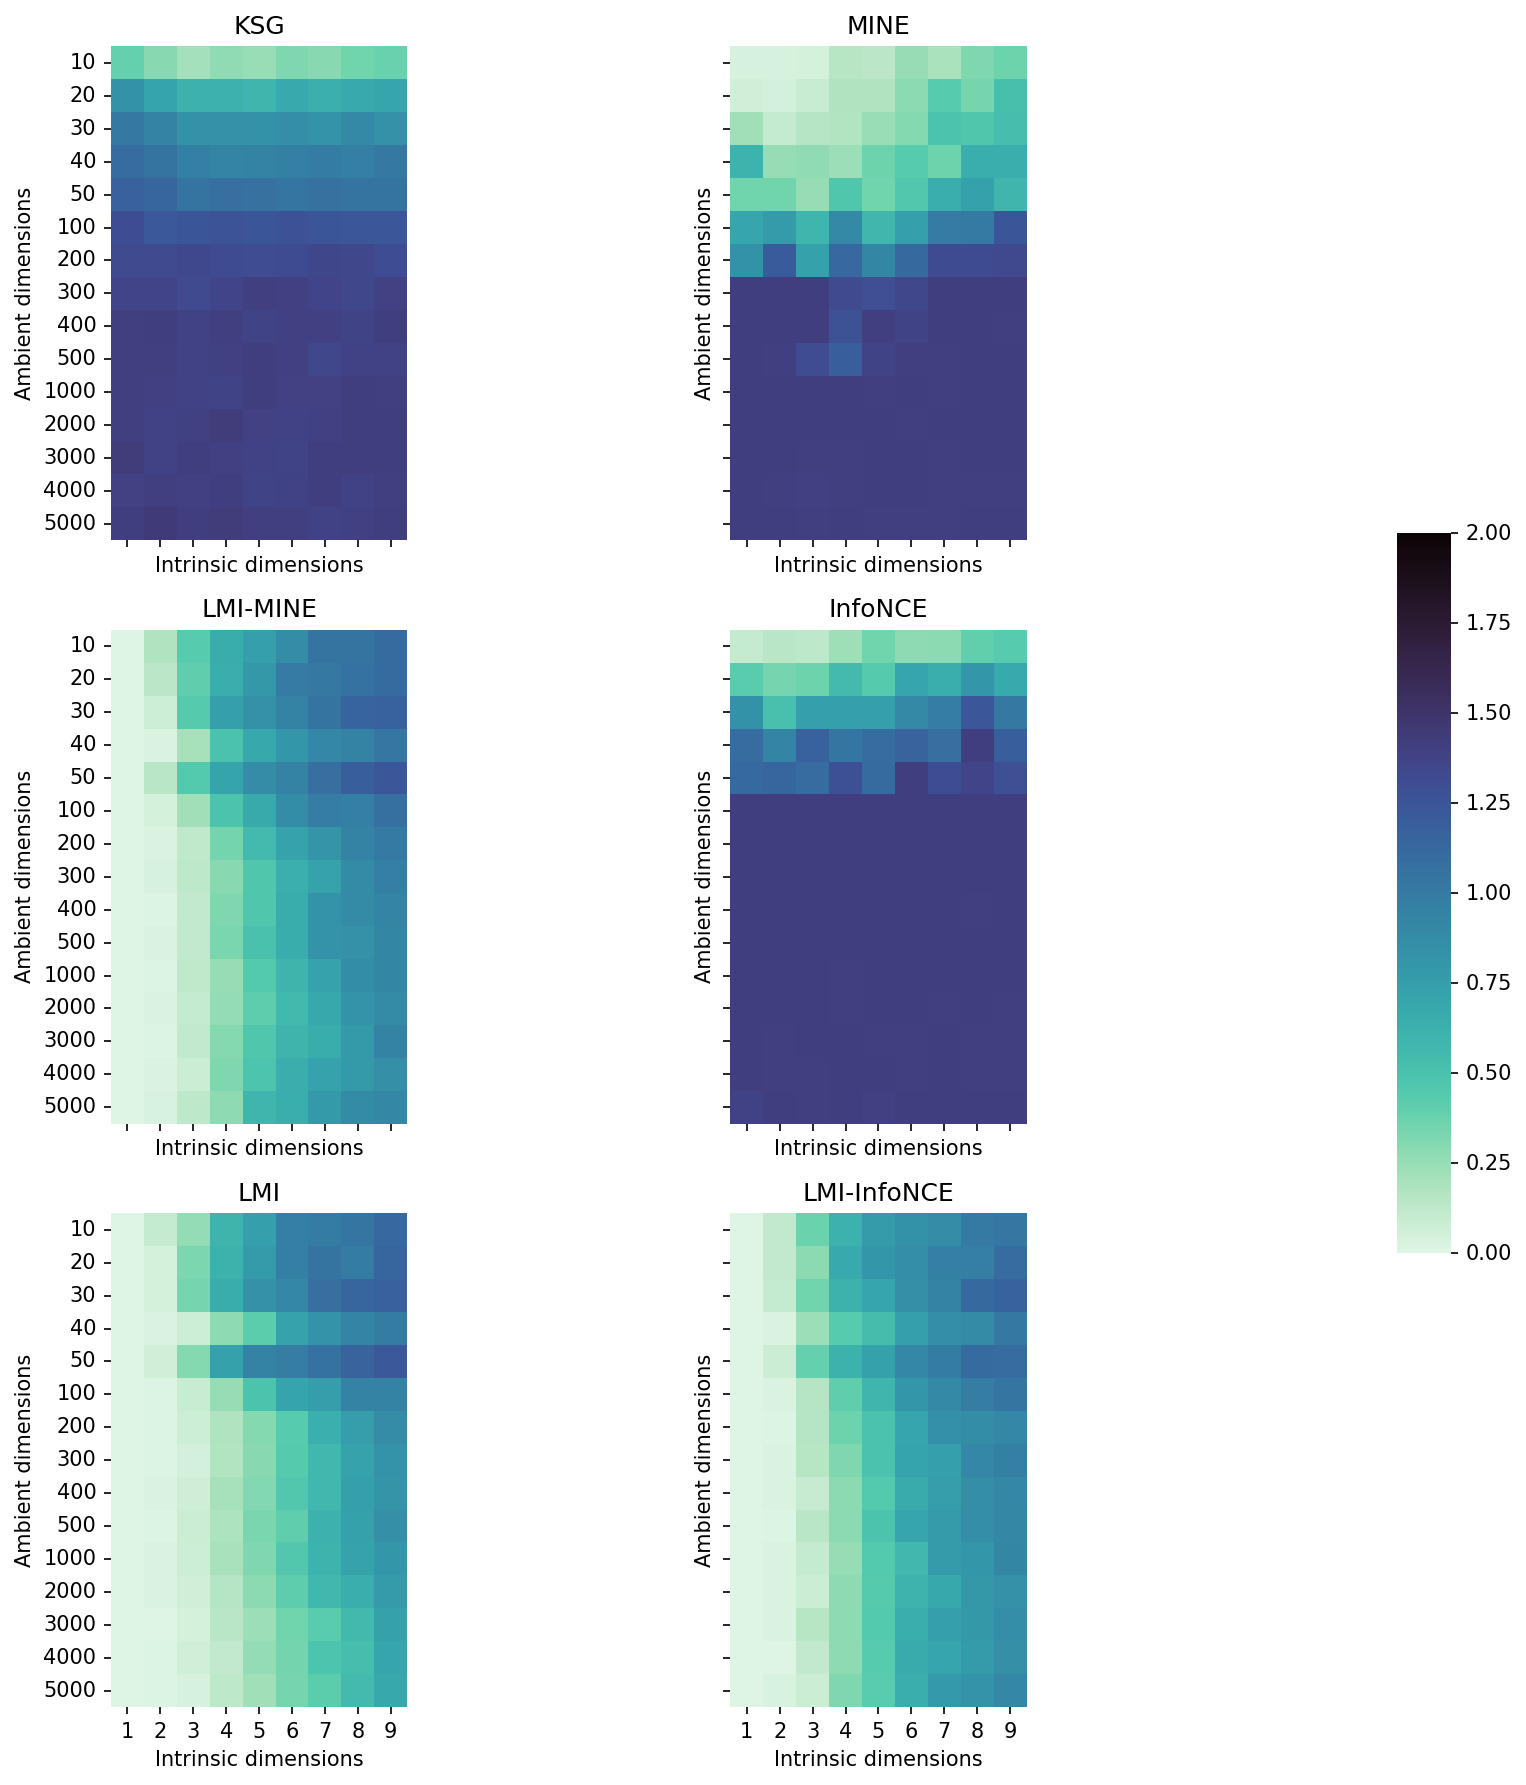

In [6]:
fig, axn = plt.subplots(3, 2, sharex=True, sharey=True, 
                        figsize=(12,12), dpi=150)

cbar_ax = fig.add_axes([.91, .3, .03, .4])

k = g.apply(mse).unstack().fillna(0)
ests = list(set(res_df['Estimator']))
for i, ax in enumerate(axn.flat):
    sns.heatmap(k.reset_index().pivot_table(index='Ambient dimensions',
                            columns='Intrinsic dimensions',
                            values=ests[i]), square=True, cmap='mako_r',
                ax=ax,
                cbar=i == 0,
                vmin=0, vmax=2,
                cbar_ax=None if i else cbar_ax)
    ax.set_title(ests[i])

# axn.flat[5].remove()

fig.tight_layout(rect=[0, 0, .9, 1])

In [7]:
res_df.to_csv("../results/MI_Gaussian_grids.csv")